In [23]:
import io
import requests
import json
import csv
import random
import base64
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import aifc
import seaborn as sns


In [18]:

datafolder = "/Users/george/Downloads/whale-detection-challenge/data/"
trainfolder = datafolder+"train/"

whale_samples = []
not_whale_samples = []
with open(datafolder+"train.csv") as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        is_whale = row['label'] == '1'
        filename = row['clip_name']
        if (is_whale):
            whale_samples.append(filename)
        else:
            not_whale_samples.append(filename)
    print(f"Number of whale samples: {len(whale_samples)}")
    print(f"Number of not-whale samples: {len(not_whale_samples)}")

# Get a random subset of 3500 whale and not-whale samples
# We are going to use 2500 of each class to train the model, and 1000 of each class to test the model
random.seed(2350834243)
whale_subset = random.sample(whale_samples, 3500)
not_whale_subset = random.sample(not_whale_samples, 3500)
whale_subset_train = whale_subset[:2500]
whale_subset_test = whale_subset[2500:]
not_whale_subset_train = not_whale_subset[:2500]
not_whale_subset_test = not_whale_subset[2500:]

print(f"Count of whale training set: {len(whale_subset_train)}")
print(f"Count of not-whale training set: {len(not_whale_subset_train)}")
print(f"Count of whale test set: {len(whale_subset_test)}")
print(f"Count of not-whale test set: {len(not_whale_subset_test)}")


Number of whale samples: 7027
Number of not-whale samples: 22973
Count of whale training set: 2500
Count of not-whale training set: 2500
Count of whale test set: 1000
Count of not-whale test set: 1000


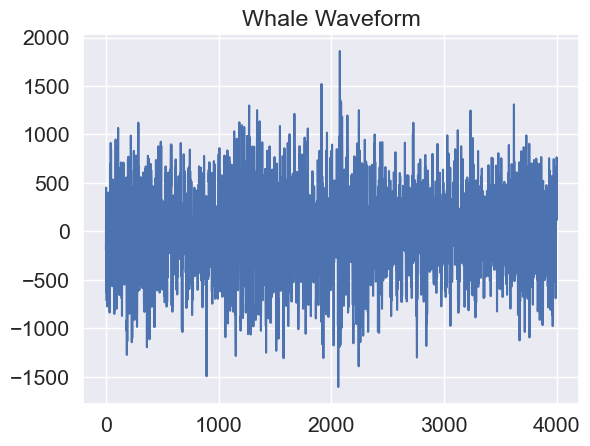

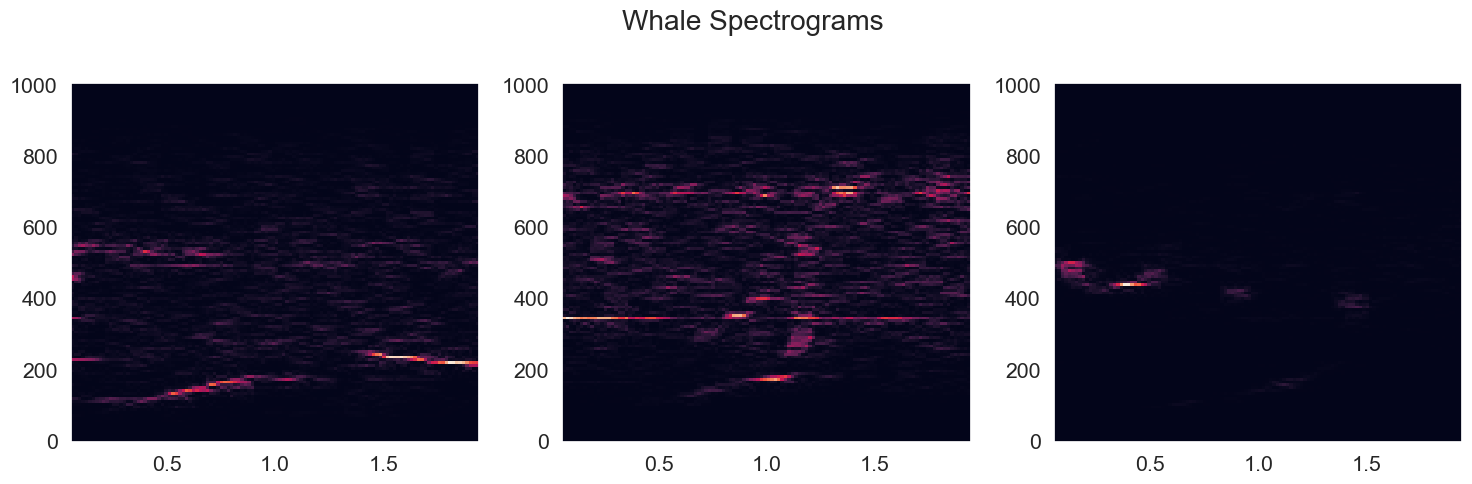

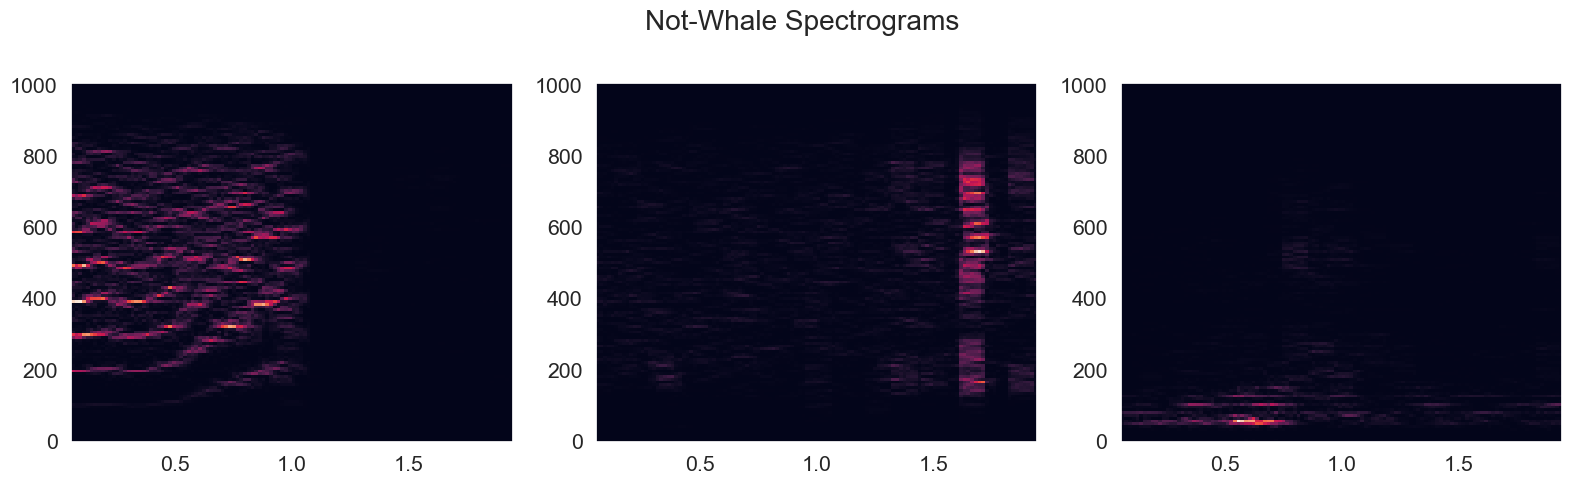

In [47]:
# Helper class for creating a spectrogram from an audio signal
class Spectrogram:

    ## Open an audio file and return the time series and sample rate
    def get_time_series(self, image_path):
        s = aifc.open(image_path)
        strsig = s.readframes(s.getnframes())
        values = np.frombuffer(strsig, np.short).byteswap()
        return values, s.getframerate()

    ## Create a spectrogram from the time series and sample rate
    def plot_spectrogram(self, image_path, plot):
        series, rate = self.get_time_series(image_path)
        f, t, Sxx = signal.spectrogram(series, rate, nperseg=256, noverlap=224)
        plot.pcolormesh(t, f, Sxx)

    ## Save the plot to a byte array
    def get_plot_bytes(self, plt):
        with io.BytesIO() as buffer:  # use buffer memory
            plt.savefig(buffer, format='jpg')
            buffer.seek(0)
            return buffer.getvalue()

    ## Process an audo file and return the spectrogram as a byte array
    def process_audio(self, image_path):
        fig = plt.figure()
        self.plot_spectrogram(image_path, fig)
        plot_bytes = self.get_plot_bytes(fig)
        fig.close()
        return plot_bytes

spectrogram = Spectrogram()

# Let's plot the waveform of a whale sample
series, rate = spectrogram.get_time_series(trainfolder+whale_subset_train[0])
plt.plot(series)
plt.title("Whale Waveform")
plt.savefig("whale_waveform.png")
plt.show()

# Let's look at some spectrograms of whale sounds
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle("Whale Spectrograms")
fig.tight_layout()
for i, sample in enumerate(random.sample(whale_subset_train,3)):
    spectrogram.plot_spectrogram(trainfolder+sample, ax[i])
fig.savefig("whale_spectrograms.png")

# Let's look at some spectrograms of not-whale sounds
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
fig.suptitle("Not-Whale Spectrograms")
fig.tight_layout()
for i, sample in enumerate(random.sample(not_whale_subset_train,3)):
    spectrogram.plot_spectrogram(trainfolder+sample, ax[i])
fig.savefig("not_whale_spectrograms.png")

In [2]:
# Create a helper class for nyckel API
# Has methods to create an image classification function, add training samples to the function, and invoke the function to get predictions
class Nyckel:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.auth_token = ''

    # Ensure we have an auth token
    def ensure_auth_token(self):
        if not self.auth_token:
            data = {'client_id': self.client_id, 'client_secret': self.client_secret,
                    'grant_type': 'client_credentials'}
            result = requests.post(
                'https://www.nyckel.com/connect/token', data=data)
            self.auth_token = json.loads(result.text)['access_token']

    # Create a new image classification function and add the provided labels (classes)
    def create_function(self, name, label_names):
        self.ensure_auth_token()
        result = requests.post(
            f"https://www.nyckel.com/v1/functions",
            json={"name": name, "input": "Image", "output": "Classification"},
            headers={"authorization": "Bearer " + self.auth_token})
        function_id = json.loads(result.text)['id'].replace("function_", "")
        for label_name in label_names:
            requests.post(
                f"https://www.nyckel.com/v1/functions/{function_id}/labels",
                json={"name": label_name},
                headers={"authorization": "Bearer " + self.auth_token})
        return function_id

    # Encode an image as base64 string for posting to the API
    def base64encoded_image(self, img_bytes):
        encoded_string = base64.b64encode(img_bytes).decode("utf-8")
        return "data:image/jpg;base64," + encoded_string

    # Add a training sample to the function annoated with the provided label_name
    def post_image(self, function_id, image_bytes, external_id, label_name):
        self.ensure_auth_token()
        base64_image = self.base64encoded_image(image_bytes)
        json = {"data": base64_image, "externalId": external_id,
                "annotation": {"labelName": label_name}}
        result = requests.post(
            f"https://www.nyckel.com/v1/functions/{function_id}/samples",
            json=json,
            headers={"authorization": "Bearer " + self.auth_token})

    # Invoke the function to get a prediction for the provided image. Returns the predicted label name
    def predict_image(self, function_id, image_bytes):
        self.ensure_auth_token()
        base64_image = self.base64encoded_image(image_bytes)
        data = {"data": base64_image}
        result = requests.post(
            f"https://www.nyckel.com/v1/functions/{function_id}/invoke",
            json=data,
            headers={"authorization": "Bearer " + self.auth_token})
        return json.loads(result.text)['labelName']

# Insert client_id and client_secret for nyckel below
client_id = ""
client_secret = ""
nyckel = Nyckel(client_id, client_secret)

In [36]:

# Create an image classification function with labels "whale" and "not whale"
function_id = nyckel.create_function("whale_test", ["whale", "not whale"])
print(f"Created function {function_id}")

# Add training samples containing whale sounds to the function
print("Adding whale samples")
for sample in whale_subset_train:
    filename = trainfolder+sample
    image_bytes = spectrogram.process_audio(filename)
    nyckel.post_image(function_id, image_bytes, sample, "whale")

# Add training samples without whale sounds to the function
print("Adding not-whale samples")
for sample in not_whale_subset_train:
    filename = trainfolder+sample
    image_bytes = spectrogram.process_audio(filename)
    nyckel.post_image(function_id, image_bytes, sample, "not whale")

print("Done adding samples")

Created function aq3a4rf4renzwdms
Adding whale samples
Adding not-whale samples
Done adding samples


In [ ]:
#function_id = "aq3a4rf4renzwdms"
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

print("Predicting whale test samples")
for sample in whale_subset_test:
    result = nyckel.predict_image(function_id, spectrogram.process_audio(trainfolder+sample))
    if(result == "whale"):
        true_positives += 1
    else:
        false_negatives += 1

print("Predicting not-whale test samples")
for sample in not_whale_subset_test:
    result = nyckel.predict_image(function_id, spectrogram.process_audio(trainfolder+sample))
    if(result == "not whale"):
        true_negatives += 1
    else:
        false_positives += 1


True positives: 866
False positives: 157
True negatives: 843
False negatives: 134
Accuracy: 0.8545


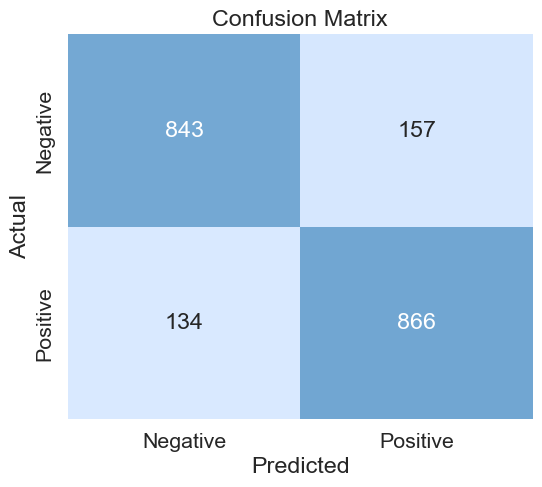

In [32]:

print(f"True positives: {true_positives}")
print(f"False positives: {false_positives}")
print(f"True negatives: {true_negatives}")
print(f"False negatives: {false_negatives}")

print(f"Accuracy: {(true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)}")

## Create and show a confusion matrix
confusion_matrix = np.array([[true_negatives, false_positives],
                             [false_negatives, true_positives]])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.set(font_scale=1.4)
light_blue_palette = LinearSegmentedColormap.from_list(
    "light_blue", ['#d9e9ff', '#71a6d2'], N=256)
sns.heatmap(confusion_matrix, annot=True, cmap=light_blue_palette, fmt='g', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# save the confusion matrix to a png file
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
